In [3]:
import sys
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig()

import bardensr
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import ray
import matplotlib.patches
import numpy.random as npr
import bardensr.registration.lowrankregistration
import os
import bardensr.registration
import tqdm.notebook
import bardensr.plotting
import scipy as sp
import skimage.feature
import scipy.spatial
import pkg_resources
import bardensr.misc
import bardensr.barcodediscovery
import bardensr.benchmarks
import dataclasses
import scipy.misc
import bardensr.registration.lowrankregistration

# simple translation

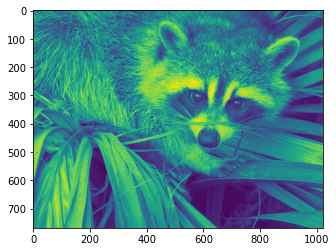

In [5]:
X=scipy.misc.face(gray=True)
plt.imshow(X)

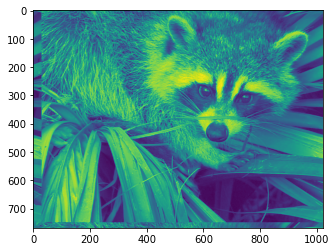

In [5]:
Y=np.roll(X,-20,axis=0)
Y=np.roll(Y,30,axis=1)
plt.imshow(Y)

In [6]:
bardensr.registration.normcorrregister_pair(X,Y,cutin=50)

array([-20,  30])

In [7]:
data=np.stack([X,Y],axis=0).astype(float)
ts=bardensr.registration.erdem_normcorregister(data)
ts

array([[ 10., -15.],
       [-10.,  15.]])

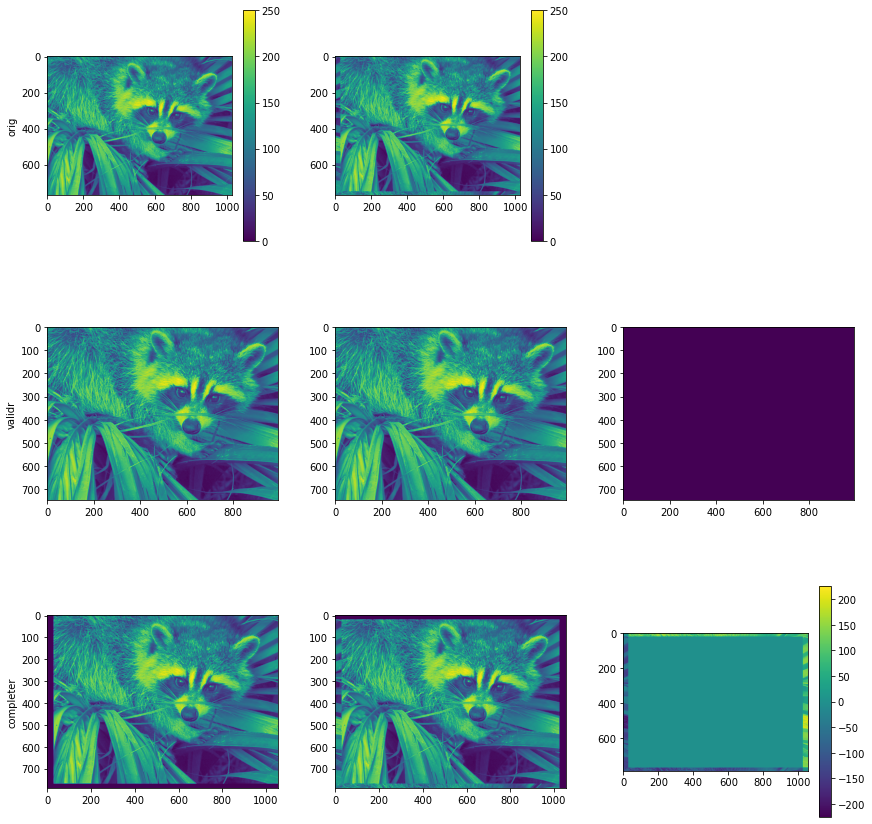

In [9]:
with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    a.cb(plt.imshow(data[0]))
    plt.ylabel('orig')
    ~a
    a.cb(plt.imshow(data[1]))
    ~a
    plt.axis("off")
    
    
    datar,newt=bardensr.registration.apply_translation_registration(data.astype(float),ts,mode='valid')
    ~a
    plt.imshow(datar[0])
    plt.ylabel("validr")
    ~a
    plt.imshow(datar[1])
    ~a
    plt.imshow(datar[0]-datar[1])
    
    datar,newt=bardensr.registration.apply_translation_registration(data.astype(float),ts,mode='complete')
    ~a
    plt.imshow(datar[0])
    plt.ylabel('completer')
    ~a
    plt.imshow(datar[1])
    ~a
    a.cb(plt.imshow(datar[0]-datar[1]))

# large affine registration

In [10]:
affines=np.concatenate([
    np.zeros((2,2)),
    np.r_[0,0][:,None],
],axis=1)
sz=(200,300)
rez=bardensr.registration.apply_large_affine_registration(X,affines,sz)
assert np.allclose(rez,X[:200,:300])

In [11]:
affines=np.concatenate([
    np.diag([0,1]),
    np.r_[0,0][:,None],
],axis=1)
sz=(200,300)
rez=bardensr.registration.apply_large_affine_registration(X,affines,sz)
assert np.allclose(rez,X[:200,:600:2])

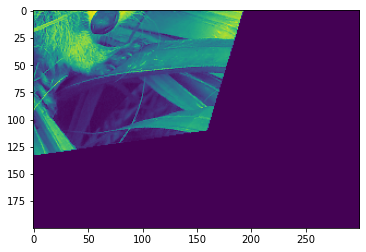

In [12]:
npr.seed(0)
affines=np.concatenate([
    npr.randn(2,2),
    np.r_[400,400][:,None],
],axis=1)
sz=(200,300)
rez=bardensr.registration.apply_large_affine_registration(X,affines,sz)
plt.imshow(rez)


assert np.allclose(rez[20,30],X[tuple(np.r_[20,30]+np.round(affines@np.r_[20,30,1]).astype(int))])

# example problem -- data is affined, correction is rigid

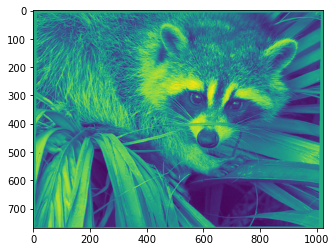

In [13]:
npr.seed(0)
affines=np.concatenate([
    npr.randn(2,2)*0.01,
    np.r_[-12,-15][:,None],
],axis=1)
sz=X.shape
rez=bardensr.registration.apply_large_affine_registration(X,affines,sz,constant_values=155.0)
plt.imshow(rez)

data=np.stack([X,rez],axis=0)
assert np.allclose(rez[20,30],X[tuple(np.r_[20,30]+np.round(affines@np.r_[20,30,1]).astype(int))])

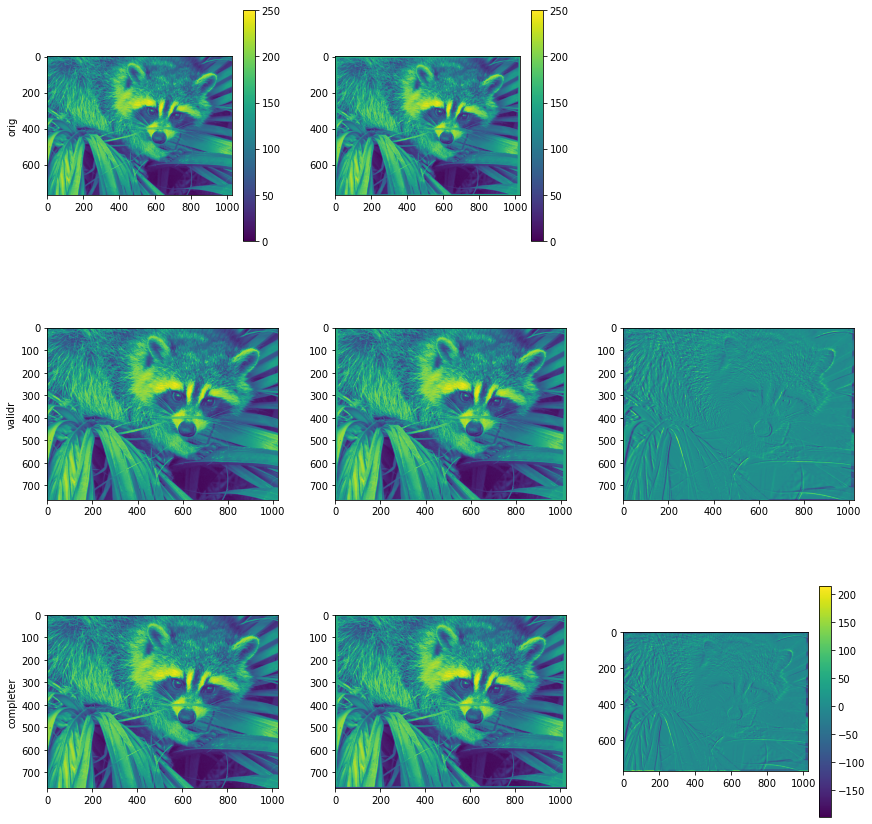

In [14]:
ts=bardensr.registration.erdem_normcorregister(data)

with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    a.cb(plt.imshow(data[0]))
    plt.ylabel('orig')
    ~a
    a.cb(plt.imshow(data[1]))
    ~a
    plt.axis("off")
    
    
    datar,newt=bardensr.registration.apply_translation_registration(data.astype(float),ts,mode='valid')
    ~a
    plt.imshow(datar[0])
    plt.ylabel("validr")
    ~a
    plt.imshow(datar[1])
    ~a
    plt.imshow(datar[0]-datar[1])
    
    datar,newt=bardensr.registration.apply_translation_registration(data.astype(float),ts,mode='complete')
    ~a
    plt.imshow(datar[0])
    plt.ylabel('completer')
    ~a
    plt.imshow(datar[1])
    ~a
    a.cb(plt.imshow(datar[0]-datar[1]))

# example problem -- data is affined, correction is affine (learned from local translation blocks)

In [4]:
# make example
npr.seed(0)
affines=np.concatenate([
    npr.randn(2,2)*0.01,
    np.r_[-12,-15][:,None],
],axis=1)
sz=X.shape
rez=bardensr.registration.apply_large_affine_registration(X.astype(float),affines,sz,constant_values=0.0)
plt.imshow(rez)

data=np.stack([X,rez],axis=0).astype(float)

NameError: name 'X' is not defined

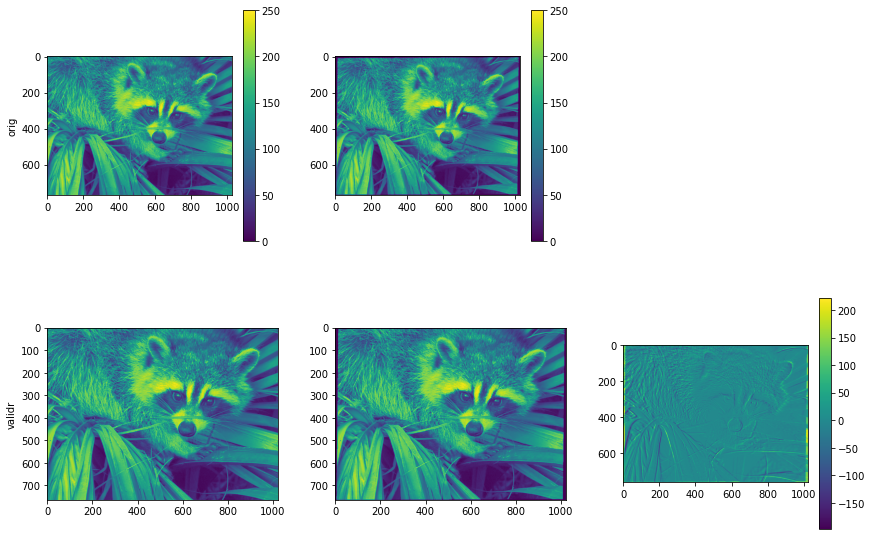

In [16]:
# note that naive method doesn't work so great
ts=bardensr.registration.erdem_normcorregister(data)
with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    a.cb(plt.imshow(data[0]))
    plt.ylabel('orig')
    ~a
    a.cb(plt.imshow(data[1]))
    ~a
    plt.axis("off")
    
    
    datar,newt=bardensr.registration.apply_translation_registration(data.astype(float),ts,mode='valid')
    ~a
    plt.imshow(datar[0])
    plt.ylabel("validr")
    ~a
    plt.imshow(datar[1])
    ~a
    a.cb(plt.imshow(datar[0]-datar[1]))

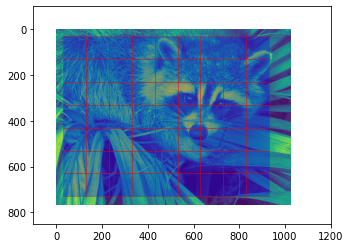

In [18]:
# can do better by tiling it up
tiles=bardensr.rectangles.tiling.tile_up_nd(X.shape,(100,100),(30,30),outer_border=False,last_edge_behavior='drop')

plt.imshow(X)
for tile in tiles:

    rect=matplotlib.patches.Rectangle(tile.put.start[::-1],*tile.put.size[::-1],
                                      facecolor=f'blue',alpha=.3,edgecolor='red')
    plt.gca().add_patch(rect)

#     rect=matplotlib.patches.Rectangle(tile.look.start[::-1],*tile.look.size[::-1],
#                                       facecolor=f'blue',alpha=.3,edgecolor='red')
#     plt.gca().add_patch(rect)



    plt.xlim(-100,1200)
    plt.ylim(850,-100)


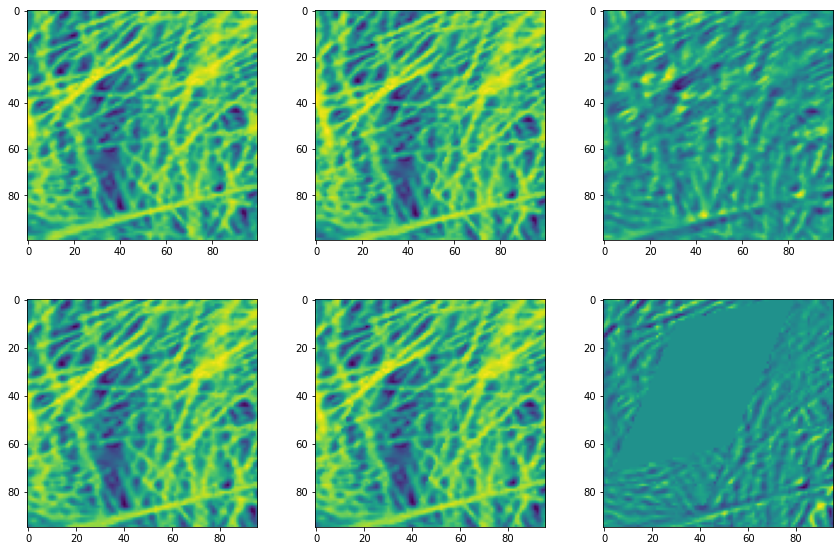

In [19]:
# and doing local tiles
tile=tiles[30]
subdata=data[(slice(0,None),*tile.put.as_slices)]
# subdata=subdata-np.mean(subdata,axis=(1,2),keepdims=True)

with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    plt.imshow(subdata[0])
    ~a
    plt.imshow(subdata[1])
    ~a
    plt.imshow(subdata[0]-subdata[1])
    
    t=bardensr.registration.erdem_normcorregister(subdata)
    subdatar,t=bardensr.registration.apply_translation_registration(subdata,t)
    ~a
    plt.imshow(subdatar[0])
    ~a
    plt.imshow(subdatar[1])
    ~a
    plt.imshow(subdatar[0]-subdatar[1])
    

In [21]:
# trying this globally.
datar=np.zeros(data.shape)

ts=[]
tcs=[]
for tile in tqdm.notebook.tqdm(tiles):
    subdata=data[(slice(0,None),*tile.look.as_slices)]
    t=bardensr.registration.erdem_normcorregister(subdata,cutin=20)
    
    # make frame 0 have no translation
    t=t-t[0][None,:] 
    
    # grab the "put" range that we need (offset by suitable ts)
    proced=bardensr.registration.translations_tf.floating_slices(data,t+tile.put.start[None,:],tile.put.size,'nearest')
    datar[(slice(0,None),*tile.put.as_slices)]=proced
    
    
#     subdata=data[(slice(0,None),*tile.look.as_slices)]
#     subdatar,newt=bardensr.registration.apply_translation_registration(subdata,t)
    
#     tile.put.start + newt[0]
    
    
    ts.append(t)
    tcs.append(tile.put.center)
ts=np.array(ts)
tcs=np.array(tcs)
tcs_with_one=np.c_[tcs,np.ones(len(tcs))]

  0%|          | 0/63 [00:00<?, ?it/s]

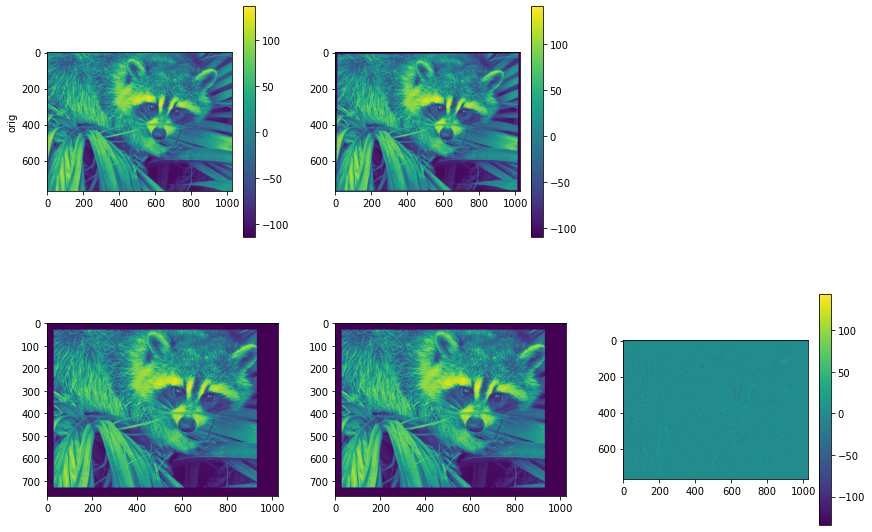

In [22]:
# results are pretty good
data=data.astype(float)-np.mean(data,axis=(1,2),keepdims=True)

with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    a.cb(plt.imshow(data[0]))
    plt.ylabel('orig')
    ~a
    a.cb(plt.imshow(data[1]))
    ~a
    plt.axis("off")
    
    
    ~a
    plt.imshow(datar[0])
    ~a
    plt.imshow(datar[1])
    ~a
    a.cb(plt.imshow(datar[0]-datar[1]))
    
   

In [23]:
# can we reconstruct the affine?

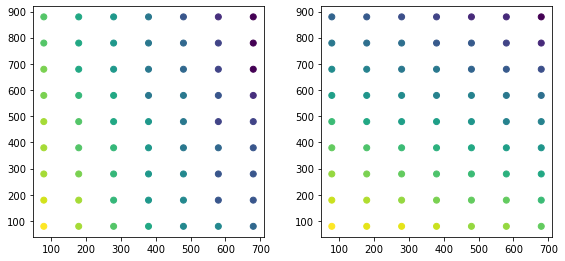

In [24]:
# put ts in reference from of 0
ts_recentered = ts-ts[:,[0],:]

# look at it 
with bardensr.plotting.AnimAcross() as a:
    ~a
    plt.scatter(tcs[:,0],tcs[:,1],c=ts_recentered[:,1,0])
    ~a
    plt.scatter(tcs[:,0],tcs[:,1],c=ts_recentered[:,1,1])

In [25]:
# calc best-fit affine transformation
affines_est=np.linalg.lstsq(tcs_with_one,ts_recentered.reshape((len(tiles),-1)),rcond=None)[0]
affines_est=affines_est.reshape((-1,)+ts[0].shape)
affines_est=np.swapaxes(affines_est,0,1)
affines_est=np.swapaxes(affines_est,2,1)

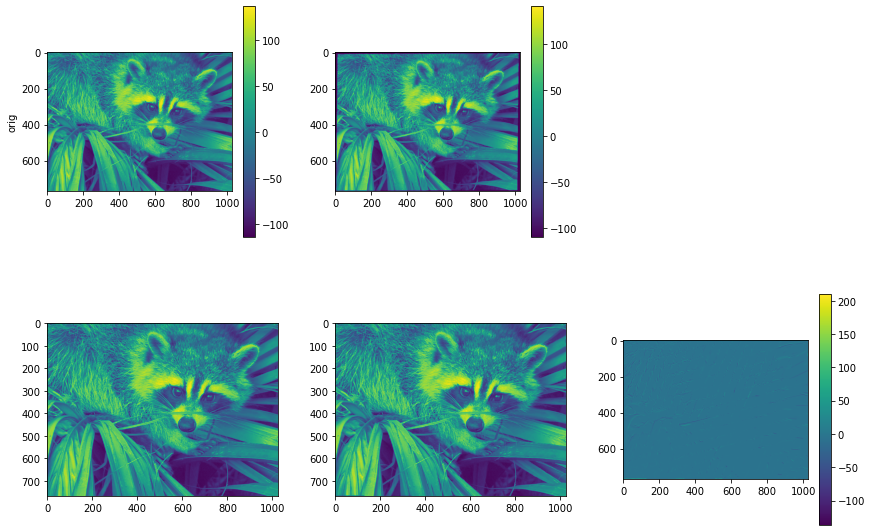

In [26]:
# what if we apply our learned affine transformation globally?
datar=data.copy()
datar[1]=bardensr.registration.apply_large_affine_registration(data[1],affines_est[1],data.shape[1:])

with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    a.cb(plt.imshow(data[0]))
    plt.ylabel('orig')
    ~a
    a.cb(plt.imshow(data[1]))
    ~a
    plt.axis("off")
    
    
    ~a
    plt.imshow(datar[0])
    ~a
    plt.imshow(datar[1])
    ~a
    a.cb(plt.imshow(datar[0]-datar[1]))
    
   

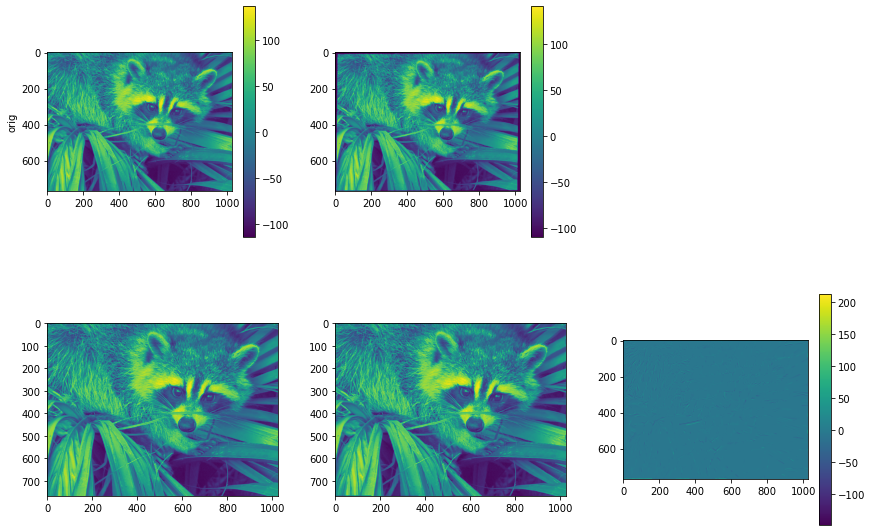

In [27]:
# what if we apply our learned affine transformation locally in patches?  also good!
datar=data.copy()
datar[1]=bardensr.registration.apply_small_affine_registration(data[1],affines_est[1],data.shape[1:])

with bardensr.plotting.AnimAcross(columns=3) as a:
    ~a
    a.cb(plt.imshow(data[0]))
    plt.ylabel('orig')
    ~a
    a.cb(plt.imshow(data[1]))
    ~a
    plt.axis("off")
    
    
    ~a
    plt.imshow(datar[0])
    ~a
    plt.imshow(datar[1])
    ~a
    a.cb(plt.imshow(datar[0]-datar[1]))
    
   

# example problem -- starmap data

In [6]:
DATA_PATH = pkg_resources.resource_filename('bardensr.benchmarks', 'ab701a5a-2dc3-11eb-9890-0242ac110002.hdf5')
bench=bardensr.benchmarks.load_h5py(DATA_PATH)

# we'll be looking at X, store R,C
X=bench.X
R,C=X.shape[:2]
R,C,J=bench.codebook.shape

# preprocess X
X=X-np.min(X,axis=(2,3,4),keepdims=True)
X=X/np.max(X,axis=(2,3,4),keepdims=True)

# flatten out frames
Xflat=np.reshape(X,(R*C,)+X.shape[3:])
codeflat=np.reshape(bench.codebook,(R*C,J))
codetf = tf.identity(codeflat.astype(np.float64))
codetf=codetf/tf.math.sqrt(tf.reduce_sum(codetf**2,axis=0,keepdims=True))
    

# screw up one of the frames
Xflat[3] = np.roll(Xflat[3],4,axis=0)

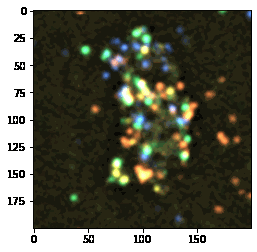

<Figure size 432x288 with 0 Axes>

In [7]:
# so they're not registered
with bardensr.plotting.AnimGif() as ag:
    for r in range(2):
        plt.clf()
        plt.imshow(bardensr.plotting.lutup(*Xflat[r*4:r*4+4]))
        ag()
~ag

### global reg

In [8]:
# try to register them!
t=bardensr.registration.lowrankregister(Xflat,codeflat,use_tqdm_notebook=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
# look at loss function in neighborhood of discovered optimum

In [12]:
base=t
l,g=bardensr.registration.lowrankregistration.calc_loss_and_grad(Xflat,codeflat,base)

alphas=np.r_[-1:1:10j]*1000
ls=np.zeros(len(alphas))
for i,alpha in enumerate(tqdm.notebook.tqdm(alphas)):
    newt=base+g*alpha
    ls[i]=bardensr.registration.lowrankregistration.calc_loss(
            Xflat,codeflat,newt)


  0%|          | 0/10 [00:00<?, ?it/s]

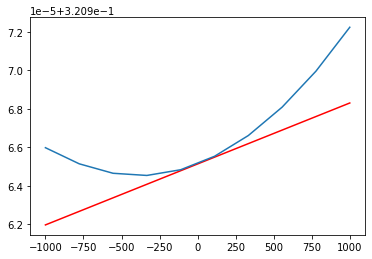

In [13]:
plt.plot(alphas,alphas*np.sum(g**2)+l,color='red')
plt.plot(alphas,ls)
# plt.axhline(losses[0],color='black')
# plt.axhline(losses[-1],color='black')

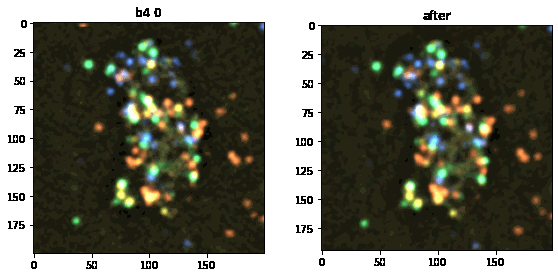

<Figure size 288x288 with 0 Axes>

In [15]:
# error is fixed.  yay
Xflatr,newt=bardensr.registration.apply_translation_registration(Xflat,t,mode='valid')
with bardensr.plotting.AnimGif() as ag:
    for r in range(2):
        plt.clf()
        with bardensr.plotting.AnimAcross(columns=2) as a:
            a(f'b4 {r}')
            plt.imshow(bardensr.plotting.lutup(*Xflat[r*4:r*4+4]))#,sc=.1,normstyle='each'))
            a('after')
            plt.imshow(bardensr.plotting.lutup(*Xflatr[r*4:r*4+4]))#,sc=.1,normstyle='each'))
        ag()
    
~ag

### tile it up

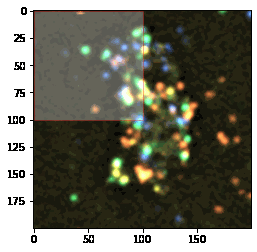

<Figure size 432x288 with 0 Axes>

In [17]:
tiles=bardensr.rectangles.tiling.tile_up_nd(Xflat.shape[1:],(40,40),(30,30),outer_border=False,last_edge_behavior='drop')

with bardensr.plotting.AnimGif() as a:
    for i,tile in enumerate(tiles):
        plt.imshow(bardensr.plotting.lutup(*Xflat[:4]))
        rect=matplotlib.patches.Rectangle(tile.look.start[::-1],*tile.look.size[::-1],
                                          facecolor=f'white',alpha=.3,edgecolor='red')
        plt.gca().add_patch(rect)
        a()
~a

### local reg, tile 0

In [21]:
# register at tile 0.  see what shakes.
tile=tiles[0]


subdata=Xflat[(slice(0,None),*tile.look.as_slices)]


t=bardensr.registration.lowrankregister(subdata,codeflat,
                            use_tqdm_notebook=True)


  0%|          | 0/50 [00:00<?, ?it/s]

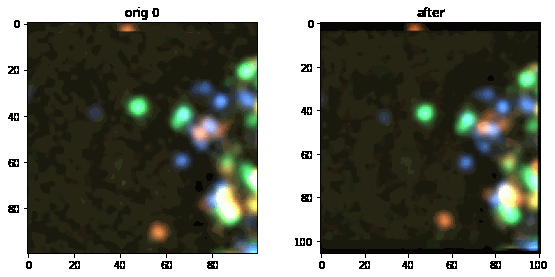

<Figure size 288x288 with 0 Axes>

In [23]:
subdatar,newt=bardensr.registration.apply_translation_registration(subdata,t,mode='complete')

with bardensr.plotting.AnimGif() as ag:
    for r in range(2):
        plt.clf()
        with bardensr.plotting.AnimAcross(columns=3) as a:
            a(f'orig {r}')
            plt.imshow(bardensr.plotting.lutup(*subdata[r*4:r*4+4]))
            a('after')
            plt.imshow(bardensr.plotting.lutup(*subdatar[r*4:r*4+4]))
        ag()
    
~ag

### local reg, tile 6

In [26]:
# register at tile 6.  see what shakes.
tile=tiles[6]


subdata=Xflat[(slice(0,None),*tile.look.as_slices)]


t =bardensr.registration.lowrankregister(subdata,codeflat,
                            use_tqdm_notebook=True)


  0%|          | 0/50 [00:00<?, ?it/s]

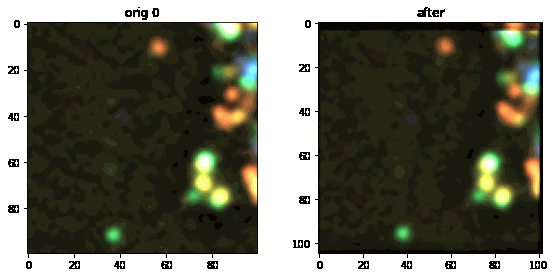

<Figure size 288x288 with 0 Axes>

In [28]:
subdatar,newt=bardensr.registration.apply_translation_registration(subdata,t,mode='complete')

with bardensr.plotting.AnimGif() as ag:
    for r in range(2):
        plt.clf()
        with bardensr.plotting.AnimAcross(columns=3) as a:
            a(f'orig {r}')
            plt.imshow(bardensr.plotting.lutup(*subdata[r*4:r*4+4]))
            a('after')
            plt.imshow(bardensr.plotting.lutup(*subdatar[r*4:r*4+4]))
        ag()
    
~ag

### register on a subset of tiles

In [30]:
ts=[]
tcs=[]
subtiles=[tiles[0],tiles[3],tiles[4]]
for tile in tqdm.notebook.tqdm(subtiles):
    subdata=Xflat[(slice(0,None),*tile.look.as_slices)]
    
    t=bardensr.registration.lowrankregister(subdata,codeflat,
                            use_tqdm_notebook=True)
    ts.append(t)
    tcs.append(tile.look.center)
ts=np.array(ts)
tcs=np.array(tcs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
# calc best-fit affine transformation 
affines_est,residual=bardensr.registration.estimate_affine_registrations(tcs,ts)

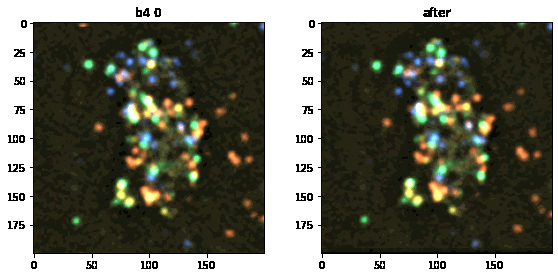

<Figure size 288x288 with 0 Axes>

In [39]:
Xflatr=bardensr.registration.apply_small_affine_registrations(Xflat,affines_est)
with bardensr.plotting.AnimGif() as ag:
    for r in range(2):
        plt.clf()
        with bardensr.plotting.AnimAcross(columns=2) as a:
            a(f'b4 {r}')
            plt.imshow(bardensr.plotting.lutup(*Xflat[r*4:r*4+4]))#,sc=.1,normstyle='each'))
            a('after')
            plt.imshow(bardensr.plotting.lutup(*Xflatr[r*4:r*4+4]))#,sc=.1,normstyle='each'))
        ag()
    
~ag